In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from sklearn.decomposition import PCA
import gc
import glob  
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import pathos.pools
from functools import partial
import os
import math
from  matplotlib.ticker import PercentFormatter
sns.set_style("white")
# sns.set_context("notebook")
sns.set_theme(style="ticks", palette="husl")
# set dask dashboard
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd
from scipy.spatial.transform import Rotation as R
# pd.options.mode.chained_assignment = None  # default='warn'
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.
client
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
from scipy.ndimage import gaussian_filter1d
import re
import random


c:\Users\erene\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50999 instead
  warnings.warn(


# Select modalities, events, parameters 

In [13]:
# List with optional commented-out modalities
modalities = [
    'NoseVector.x',        
    'NoseVector.y',          
    'EyeDirWorldCombined.x', 
    'EyeDirWorldCombined.y',  
    #'EyeDirLocalCombined.x',        
    #'EyeDirLocalCombined.y',        
    'SteeringInput',         
]


# --- Toggle events by commenting them out ---
event_filter_list = [   
    #'NoEvent', # UNCOMMENT THIS TO INCLUDE ALL EVENTS
    'StagEventNew',        
    #'FallingRocksEventNew',
    #'FogEventNew',         
    #'I_variant',           
    #'III_variant',
    #'MarketPlaceEvent',
    #'CyclistEvent',       
    # 'Panne',                  
    # 'GhostDriver',
    # 'Baustelle',          
    #'MotorcyclistEvent'    ,
]


#for the raw data plotting 
#condition_filter = 'BaseCondition'
#condition_filter = '!BaseCondition'
#condition_filter = 'HUDOnly'
#condition_filter = 'AudioOnly'
#condition_filter = 'FullLoopAR'
condition_filter = 'All Conditions'



outlier_features =  ['EyeDirWorldCombined.x', 'NoseVector.x', 'EyeDirWorldCombined.y', 'NoseVector.y']  # , 'SteeringInput' , 'EyeDirWorldCombined.z', 'NoseVector.z'     remove as needed



points_per_window = 501  # 10 seconds @ 50Hz, plus onset frame in the middle
global_sigma = 0.000001    # smoothing strength



Define and load dataframe

In [14]:
import os
import dask.dataframe as dd

# Define dtypes to load all uid files
dtypes = {
    'uid': 'str',
    'dataset': 'str',
    'city_section': 'str',
    'ExperimentalCondition': 'str',
    'EventName': 'object',
    'HitObjectName': 'object',
    'ObjectName_4': 'object',
    'ObjectName_5': 'object',
    'EventDuration': 'float64',
    'TimeStamp': 'float64'
}

# Define the path to the CSV file
dir = os.getcwd()
data_path = dir + '/data/'
# Load your specific file 
len_outlier_features = len(outlier_features)
event_name = event_filter_list[0]  # e.g., 'FogEventNew'

filepath = data_path + f"/cleaned_data/data_segment/outliers_removed_{len_outlier_features}features/steeringRemoved/segment_around_{event_name}_nearest_neighbor_steeringRemoved.csv" #x 



df = dd.read_csv(filepath, assume_missing=True, dtype=dtypes, blocksize="100MB", low_memory=False).compute()

print("DataFrame shape before event filtering:", df.shape)

# Assuming event_filter_list and condition_filter are defined elsewhere, for example:
# event_filter_list = ['YourEventName']  
# condition_filter = 'All Conditions'  # or other condition to filter on

# Filter for participants (uids) that have any of the events in event_filter_list
uids_with_events = df[df['EventName'].isin(event_filter_list)]['uid'].unique()
filtered_df = df[df['uid'].isin(uids_with_events)]

print(f"DataFrame shape after filtering for event presence ({len(uids_with_events)} uids):", filtered_df.shape)

# Further filter by experimental condition if specified
if condition_filter != 'All Conditions':
    if condition_filter == '!BaseCondition':
        filtered_df = filtered_df[filtered_df['ExperimentalCondition'] != 'BaseCondition']
        condition_filter = "Any warning (non-control)"
    else:
        filtered_df = filtered_df[filtered_df['ExperimentalCondition'] == condition_filter]

print("DataFrame shape after condition filtering:", filtered_df.shape)

# Check that required columns exist
if 'uid' not in filtered_df.columns:
    raise ValueError("❌ 'uid' column missing in the filtered dataframe")


DataFrame shape before event filtering: (80160, 88)
DataFrame shape after filtering for event presence (160 uids): (80160, 88)
DataFrame shape after condition filtering: (80160, 88)


Plot raw data for each modality

In [15]:
# # Centering and standardizing data for each observation (participant's data per modality)
# raw_all_participant_curves = []

# for (uid), sub_df in filtered_df.groupby(['uid']):

#     if not all(col in sub_df.columns for col in modalities):
#         continue

#     data = sub_df[modalities].copy()
    
#     raw_all_participant_curves.append(data.T)

# if len(raw_all_participant_curves) == 0:
#     raise ValueError("❌ No valid participant data found!")

# # Stack to 3D array: (N_windows, T, M)
# raw_data_array = np.stack(raw_all_participant_curves, axis=0)  # shape: (W, M, T)
# raw_data_array = np.transpose(raw_data_array, (0, 2, 1))  # Convert to shape (W, T, M)

# W, T, M = raw_data_array.shape
# print(f"Loaded {W} valid windows, shape = ({W}, {T}, {M})")
# time_sec = np.linspace(-5, 5, T)# Loop through each modality (M) and plot the data for each participant
# for m in range(M):
#     # Extract modality-specific data
#     raw_modality_data = raw_data_array[:, :, m]  # Shape: (W, T)
    
#     # Debug: Check the shape of the modality data
#     print(f"Modality {m} data shape: {raw_modality_data.shape}")

#     # Create a new figure for each modality
#     plt.figure(figsize=(10, 6))

#     # Plot the raw time series for each participant
#     for participant_data in raw_modality_data:
#         plt.plot(time_sec, participant_data, color='lightgray', alpha=0.5)  # Raw data

#     # Compute and plot the mean time series across participants
#     raw_mean_data = raw_modality_data.mean(axis=0)  # Mean across participants, shape: (T,)
    
#     # Debug: Check the mean data
#     print(f"Mean data for modality {m}: {raw_mean_data[:5]}")  # Print first few values of mean data
    
#     # Get the modality name from the modalities list
#     modality_name = modalities[m]  # Assuming modalities is a list of names
    
#     plt.plot(time_sec, raw_mean_data, label=f"Mean {modality_name}", color='blue', linewidth=2)  # Mean line

#     plt.axvline(0, color='black', linestyle='--', label="Event Onset (0s)")
#     plt.xlabel("Time (s)")
#     plt.ylabel(f"Modality {modality_name} Values")
#     plt.title(f"Raw Time Series for {modality_name}, {event_filter_list} , {condition_filter}")
    
#     # Set y-axis limits
#     plt.ylim(-1, 1)

#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


Plot centered and standardized variables

In [16]:
# # Centering and standardizing data for each observation (participant's data per modality)
# all_participant_curves = []

# for (uid), sub_df in filtered_df.groupby(['uid']):
#     if len(sub_df) != points_per_window:
#         print(len(sub_df),points_per_window),
#         continue  # Skip incomplete windows

#     if not all(col in sub_df.columns for col in modalities):
#         continue

#     data = sub_df[modalities].copy()

#     # Center each participant's data (curve) on its own mean
#     for modality_idx in range(data.shape[1]):
#         modality_data = data.iloc[:, modality_idx].values  # Extract modality data for current participant
#         modality_data_centered = modality_data - modality_data.mean()  # Center the data
#         data.iloc[:, modality_idx] = modality_data_centered  # Replace the modality with centered data
    
#     # Standardize each modality's data across all participants
#     scaler = StandardScaler()
#     data_scaled = scaler.fit_transform(data)
    
#     all_participant_curves.append(data_scaled.T)

# if len(all_participant_curves) == 0:
#     raise ValueError("❌ No valid participant data found!")

# # Stack to 3D array: (N_windows, T, M)
# Pca_data_array = np.stack(all_participant_curves, axis=0)  # shape: (W, M, T)
# Pca_data_array = np.transpose(Pca_data_array, (0, 2, 1))  # Convert to shape (W, T, M)

# W, T, M = Pca_data_array.shape
# print(f"Loaded {W} valid windows, shape = ({W}, {T}, {M})")
# time_sec = np.linspace(-5, 5, T)
# 
# # # Loop through each modality (M) and plot the data for each participant
# for m in range(M):
#     # Extract modality-specific data
#     modality_data = Pca_data_array[:, :, m]  # Shape: (W, T)
    
#     # Debug: Check the shape of the modality data
#     print(f"Modality {m} data shape: {modality_data.shape}")

#     # Create a new figure for each modality
#     plt.figure(figsize=(10, 6))

#     # Plot the raw time series for each participant
#     for participant_data in modality_data:
#         plt.plot(time_sec, participant_data, color='lightgray', alpha=0.5)  # Raw data

#     # Compute and plot the mean time series across participants
#     mean_data = modality_data.mean(axis=0)  # Mean across participants, shape: (T,)
    
#     # Debug: Check the mean data
#     print(f"Mean data for modality {m}: {mean_data[:5]}")  # Print first few values of mean data
    
#     # Get the modality name from the modalities list
#     modality_name = modalities[m]  # Assuming modalities is a list of names
    
#     plt.plot(time_sec, mean_data, label=f"Mean {modality_name}", color='blue', linewidth=2)  # Mean line

#     plt.axvline(0, color='black', linestyle='--', label="Event Onset (0s)")
#     plt.xlabel("Time (s)")
#     plt.ylabel(f"Modality {modality_name} Values")
#     plt.title(f"Standardized Time Series for {modality_name}, {event_filter_list} , {condition_filter}")
    
#     # Set y-axis limits
#     plt.ylim(-3, 3)

#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


# Time-wise PCA ED Curve

# PCA Settings

In [17]:
# global_sigma = 0.00001  # smoothing strength

# --- Define condition filters ---
condition_filters = [
    'BaseCondition', 
    '!BaseCondition',
    #'HUDOnly', 
    #'AudioOnly', 
    #'FullLoopAR', 
    #'All Conditions'
]


# List of colors for each condition
colors = {
    'BaseCondition': 'pink',
    '!BaseCondition': 'black',
    'HUDOnly': 'red',
    'AudioOnly': 'blue',
    'FullLoopAR': 'green',
    'All Conditions': 'purple'  
}

# Load and filter


df = dd.read_csv(filepath, assume_missing=True, dtype=dtypes, blocksize="100MB").compute()

grouped = df.groupby('uid')
event_filtered = grouped.filter(lambda x: any(event in x['EventName'].values for event in event_filter_list))

event_filtered.shape


(80160, 88)

# PCA with both per curve and per time point standardization

Timepoint 25
Diagonal entries (variance after z-scoring): [1. 1. 1. 1. 0.]
Off-diagonal entries (sample co-fluctuations): 0.03773198532223818 0.19668011048515105
Timepoint 142
Diagonal entries (variance after z-scoring): [1. 1. 1. 1. 0.]
Off-diagonal entries (sample co-fluctuations): -0.38990427718635834 -0.35961848008643493
Timepoint 191
Diagonal entries (variance after z-scoring): [1. 1. 1. 1. 0.]
Off-diagonal entries (sample co-fluctuations): -0.015221720278531914 0.08480362228059621
Timepoint 386
Diagonal entries (variance after z-scoring): [1. 1. 1. 1. 1.]
Off-diagonal entries (sample co-fluctuations): -0.02771068852772767 -0.09046451760388452
Timepoint 411
Diagonal entries (variance after z-scoring): [1. 1. 1. 1. 1.]
Off-diagonal entries (sample co-fluctuations): 0.1951958886565385 0.2389473483492438
⏩ Skipping StagEventNew (BaseCondition) - already processed
Timepoint 267
Diagonal entries (variance after z-scoring): [1. 1. 1. 1. 1.]
Off-diagonal entries (sample co-fluctuations):

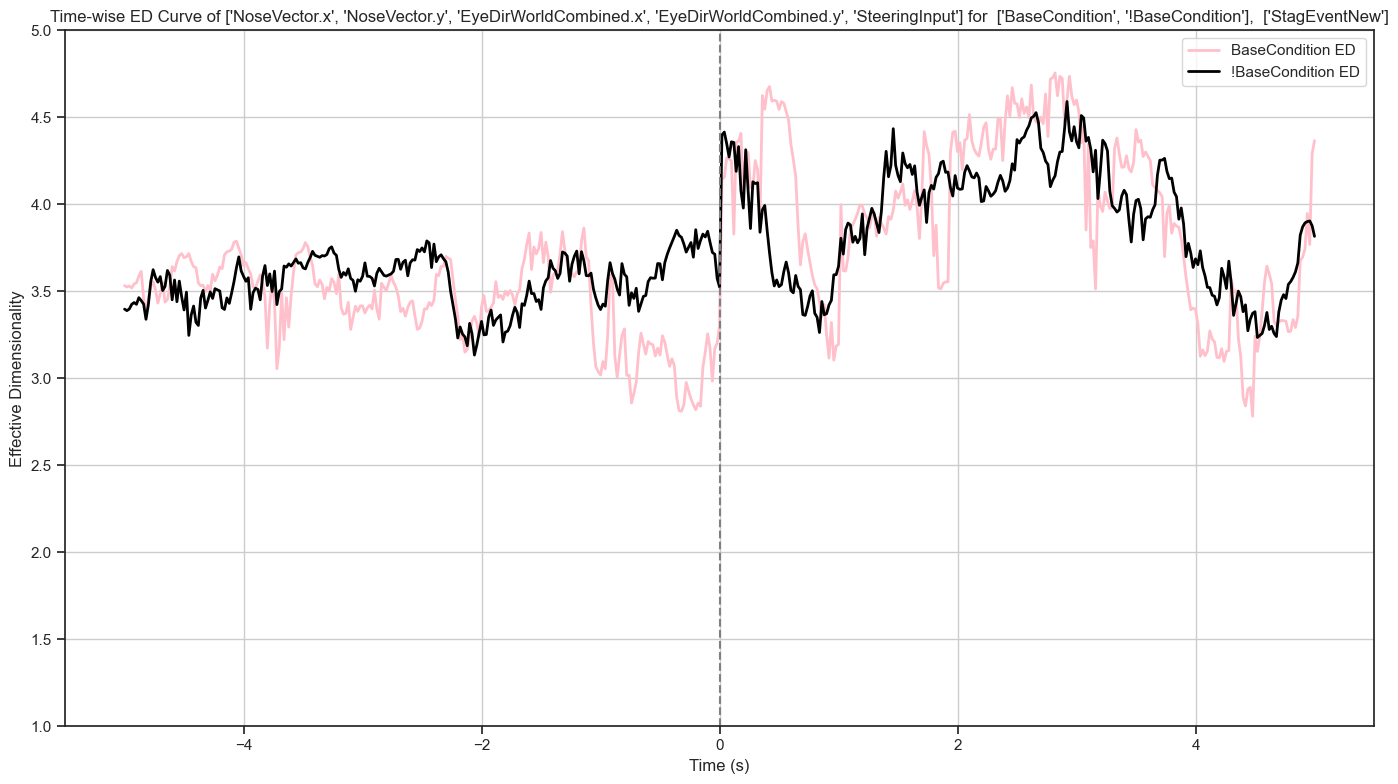

PCA based global scalar ED: 3.40 using 5 components


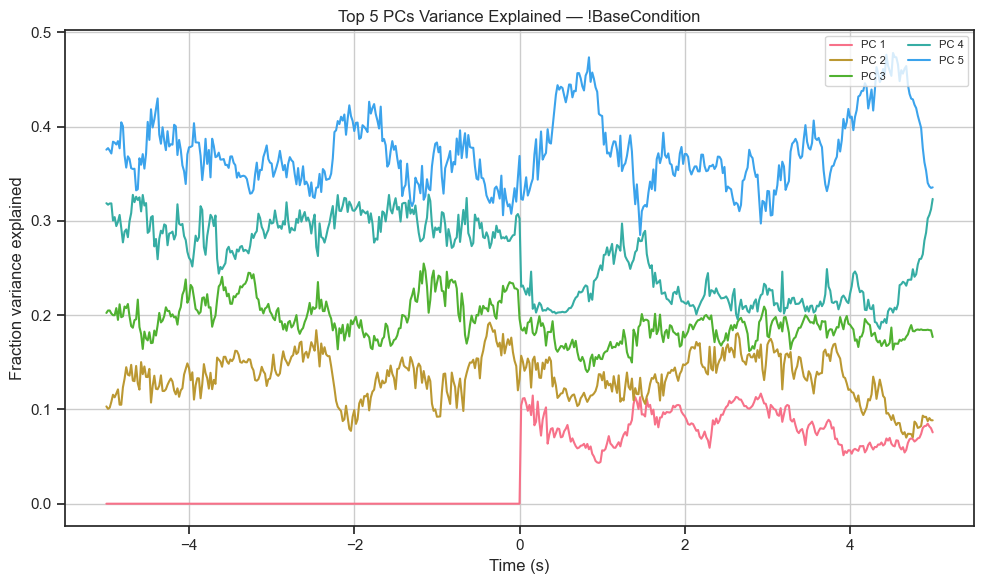

In [ ]:
# Start plotting to avoid overwriting
plt.figure(figsize=(14, 8))

for condition_filter in condition_filters:
    if condition_filter == 'BaseCondition':
        cond_df = event_filtered[event_filtered['ExperimentalCondition']=='BaseCondition']
    else:
        cond_df = event_filtered[event_filtered['ExperimentalCondition']!='BaseCondition']
    # collect per‐participant curves, centered+standardized
    all_participant_curves = []
    for (_), sub in cond_df.groupby(['uid']):
        if len(sub)!=points_per_window: continue
        data = sub[modalities].copy()
        data_scaled = StandardScaler().fit_transform(data)
        all_participant_curves.append(data_scaled.T)
    if not all_participant_curves: continue

    # stack into (W, T, M)
    Pca_data_array = np.stack(all_participant_curves, axis=0)          # (W, M, T)
    Pca_data_array = np.transpose(Pca_data_array, (0,2,1))             # (W, T, M)
    W,T,M = Pca_data_array.shape

    # compute covariance at each t
    cov_matrix = np.zeros((T, M, M))
    if 'SteeringInput' in modalities:
        steering_idx = modalities.index('SteeringInput')  # get SteeringInput column index once

    for t in range(T):
        snap = Pca_data_array[:, t, :]  # (W, M)
        snap -= snap.mean(axis=0)       # center each variable

        if t < 251:
            # Before onset: set SteeringInput values to zero to remove variance
            if 'SteeringInput' in modalities:
                snap[:, steering_idx] = 0
            
            # Standardize all other variables except SteeringInput
            for m in range(M):
                if 'SteeringInput' in modalities:
                    if m == steering_idx:
                        continue
                std = snap[:, m].std(ddof=1)
                if std > 1e-12:
                    snap[:, m] /= std
        else:
            # After onset: standardize all variables normally
            for m in range(M):
                std = snap[:, m].std(ddof=1)
                if std > 1e-12:
                    snap[:, m] /= std

        # Calculate covariance matrix for time t
        cov_matrix[t] = snap.T @ snap / (W - 1)


    # ED curve (no smoothing)
    ed = []
    for t in range(T):
        eig = eigh(cov_matrix[t], eigvals_only=True)
        p = eig/np.sum(eig)
        ed.append(1/np.sum(p**2))

    secs = np.linspace(-5,5,T)
    plt.plot(secs, ed, label=f'{condition_filter} ED', color=colors[condition_filter], linewidth=2)
    #smoothed_ed = gaussian_filter1d(ed, sigma=25)
    #plt.plot(secs, smoothed_ed, color=colors[condition_filter], linewidth=2, alpha=0.3, label='Smoothed Trend (σ=15)')

    buffer_file = f"data/ed_buffer_{len(modalities)}modalities.csv"

    # Load existing data if file exists
    if os.path.exists(buffer_file):
        existing = pd.read_csv(buffer_file)
        
        # Check if this event + condition pair already exists
        exists_pair = (
            (existing['event_name'] == event_name) &
            (existing['condition'] == condition_filter)
        ).any()
        
        if exists_pair:
            print(f"⏩ Skipping {event_name} ({condition_filter}) - already processed")
            continue  # Skip processing this condition for this event

    # After computing ED curve and building ed_df...

    ed_df = pd.DataFrame({
        'time_sec': secs,
        'ED': ed,
        'event_name': event_name,
        'condition': condition_filter
    })

    if os.path.exists(buffer_file):
        existing = pd.read_csv(buffer_file)
        combined = pd.concat([existing, ed_df], ignore_index=True)
        combined.to_csv(buffer_file, index=False)
        print(f"✅ Saved ED curve for: {event_name} ({condition_filter})")
    else:
        ed_df.to_csv(buffer_file, index=False)
        print(f"✅ Saved new ED buffer file for: {event_name} ({condition_filter})")

        

plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Effective Dimensionality")
plt.ylim(1, M)
plt.title(f"Time-wise ED Curve of {modalities} for  {condition_filters},  {event_filter_list}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# global scalar ED
eig0 = eigh(cov_matrix[0], eigvals_only=True)
eig0 = np.clip(eig0,1e-12,None)
p0 = eig0/np.sum(eig0)
ED_global = 1/np.sum(p0**2)
print(f"PCA based global scalar ED: {ED_global:.2f} using {len(eig0)} components")

# --- Variance explained per component over time ---
eigvals_time = np.zeros((T, M))
for t in range(T):
    vals = eigh(cov_matrix[t], eigvals_only=True)
    eigvals_time[t] = np.clip(vals, 1e-12, None)
frac_var = eigvals_time / eigvals_time.sum(axis=1, keepdims=True)

# plot top K components
K = min(6, M)
plt.figure(figsize=(10, 6))
secs = np.linspace(-5, 5, T)
for i in range(K):
    plt.plot(secs, frac_var[:, i], label=f"PC {i+1}")
plt.xlabel("Time (s)")
plt.ylabel("Fraction variance explained")
plt.title(f"Top {K} PCs Variance Explained — {condition_filter}")
plt.legend(loc="upper right", ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


ID MINUS ED GRAPH


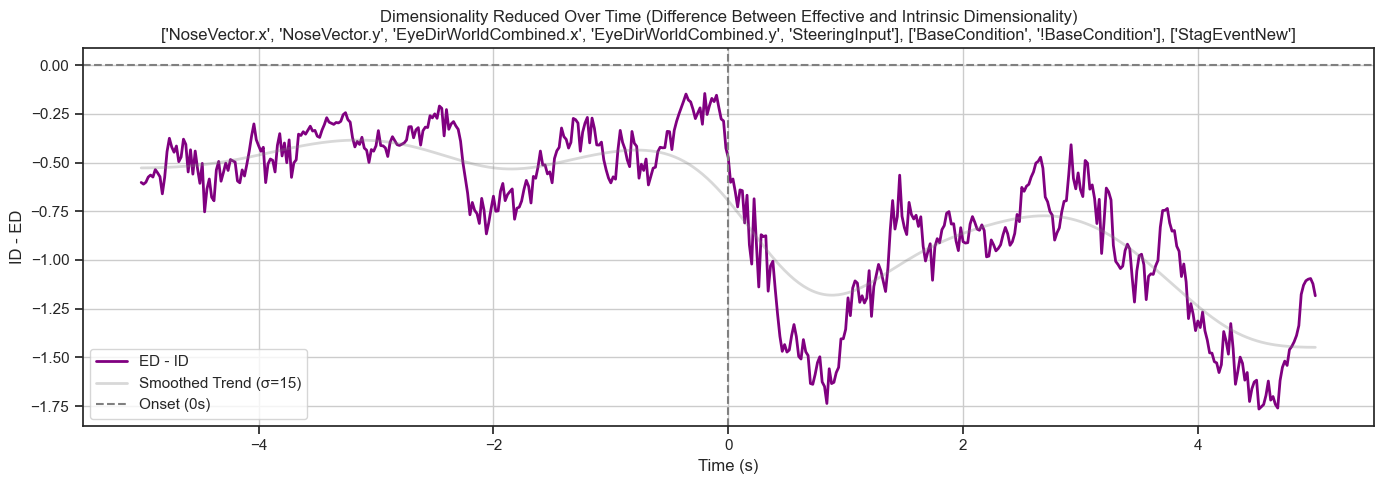

In [19]:
# Time vector
secs = np.linspace(-5, 5, T)

# Define ground-truth intrinsic dimensionality (ID): 2 before onset, 3 after

if 'SteeringInput' in modalities:
    id_curve = np.where(secs <= 0, int(len(modalities))-1, int(len(modalities)))
else:
    id_curve = np.where(secs <= 0, int(len(modalities)), int(len(modalities)))


# Compute difference: ID - ED
ed_minus_id = ed - id_curve  # or use `smoothed` if you're plotting smoothed ED
# Apply heavy smoothing to show slow temporal drift
smoothed_diff = gaussian_filter1d(ed_minus_id, sigma=25)

# Plot the difference
plt.figure(figsize=(14, 5))
plt.plot(secs, ed_minus_id, label="ED - ID", color='purple', linewidth=2)
plt.plot(secs, smoothed_diff, color='gray', linewidth=2, alpha=0.3, label='Smoothed Trend (σ=15)')

plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--', label='Onset (0s)')
plt.xlabel("Time (s)")
plt.ylabel("ID - ED")
#plt.ylim(-1.0, 0)

plt.title(f"Dimensionality Reduced Over Time (Difference Between Effective and Intrinsic Dimensionality)\n{modalities}, {condition_filters}, {event_filter_list}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Multiple events aggragated

In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def plot_ed_for_modalities(num_modalities):
    # buffer_file = f'ed_buffer_{num_modalities}modalities.csv'
    if not os.path.exists(buffer_file):
        raise FileNotFoundError(f"No buffer file found at {buffer_file}.")

    df_all = pd.read_csv(buffer_file)

    plt.figure(figsize=(14, 7))

    colors = plt.cm.get_cmap('Set2').colors
    color_idx = 0
    total_event_count = 0

    condition_filters = df_all['condition'].unique()
    modalities_from_file = df_all.columns[-num_modalities:] if num_modalities > 0 else []

    for condition_name, group_df in df_all.groupby('condition'):
        unique_events = group_df['event_name'].nunique()
        total_event_count += unique_events

        agg_df = group_df.groupby('time_sec')['ED'].mean().reset_index()

        plt.plot(
            agg_df['time_sec'], agg_df['ED'],
            label=f'{condition_name} ({unique_events} events)',
            color=colors[color_idx % len(colors)],
            linewidth=2
        )
        color_idx += 1

    plt.axvline(0, color='gray', linestyle='--', label='Event onset')
    plt.xlabel('Time (s)')
    plt.ylabel('Effective Dimensionality (ED)')
    plt.title(f'Aggregated ED curves ({int(total_event_count / len(condition_filters))} events total, {num_modalities} modalities)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- ID - ED Plot (if SteeringInput is among the modalities in original data) ---
    if 'SteeringInput' in modalities:
        print("🔍 SteeringInput detected — generating ID - ED plot...")

        plt.figure(figsize=(14, 7))
        color_idx = 0  # Reset color index to match ED plot

        for condition_name, group_df in df_all.groupby('condition'):
            ed_by_time = group_df.groupby('time_sec')['ED'].mean().reset_index()
            secs = ed_by_time['time_sec'].values
            ed = ed_by_time['ED'].values

            # Define ID (ideal dimensionality) curve
            id_curve = np.where(secs <= 0, num_modalities - 1, num_modalities)

            # Compute difference and smooth
            ed_minus_id = ed - id_curve
            smoothed_diff = gaussian_filter1d(ed_minus_id, sigma=25)

            plt.plot(
                secs, ed_minus_id,
                label=f'{condition_name} (ED - ID)',
                color=colors[color_idx % len(colors)],
                linewidth=2
            )
            color_idx += 1

        plt.axhline(0, color='gray', linestyle='--')
        plt.axvline(0, color='gray', linestyle='--', label='Onset (0s)')
        plt.xlabel("Time (s)")
        plt.ylabel("ED - ID")
        plt.title(f"Dimensionality Gap Over Time (ED - ID)\n{num_modalities} modalities with SteeringInput")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


C:\Users\erene\AppData\Local\Temp\ipykernel_18840\2001366080.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set2').colors


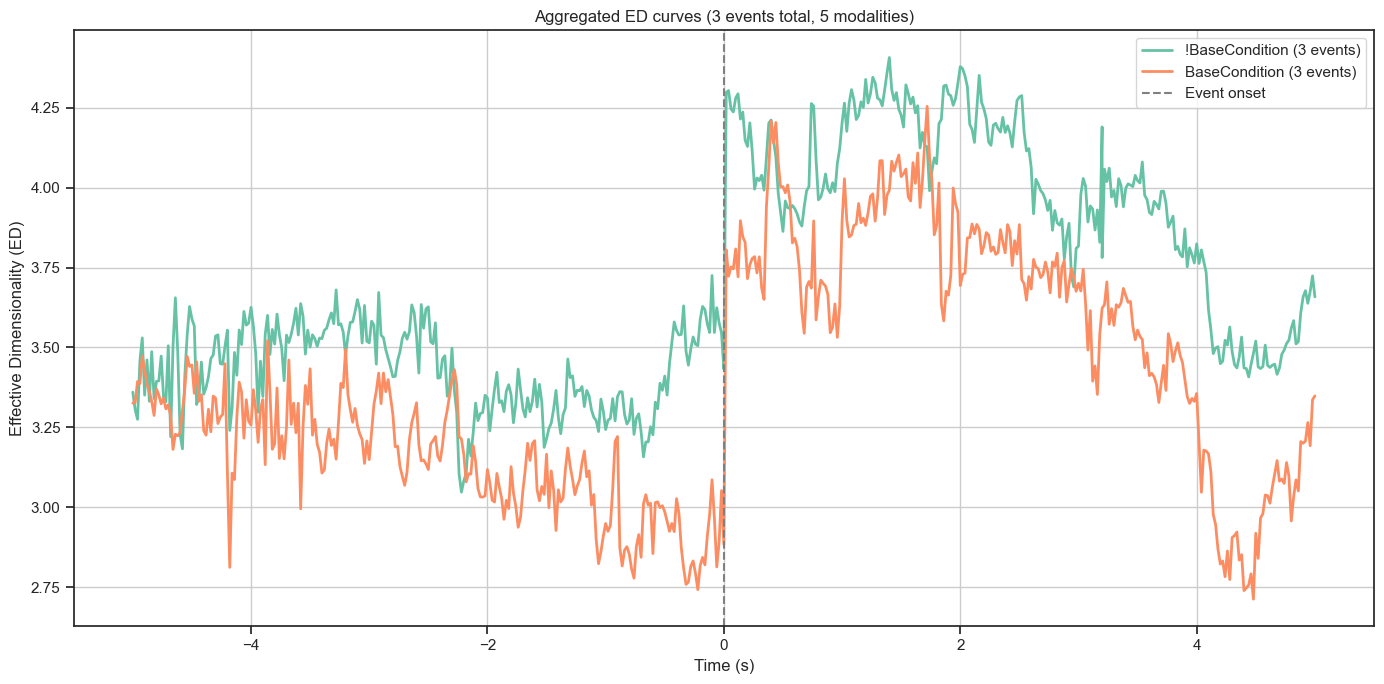

🔍 SteeringInput detected — generating ID - ED plot...


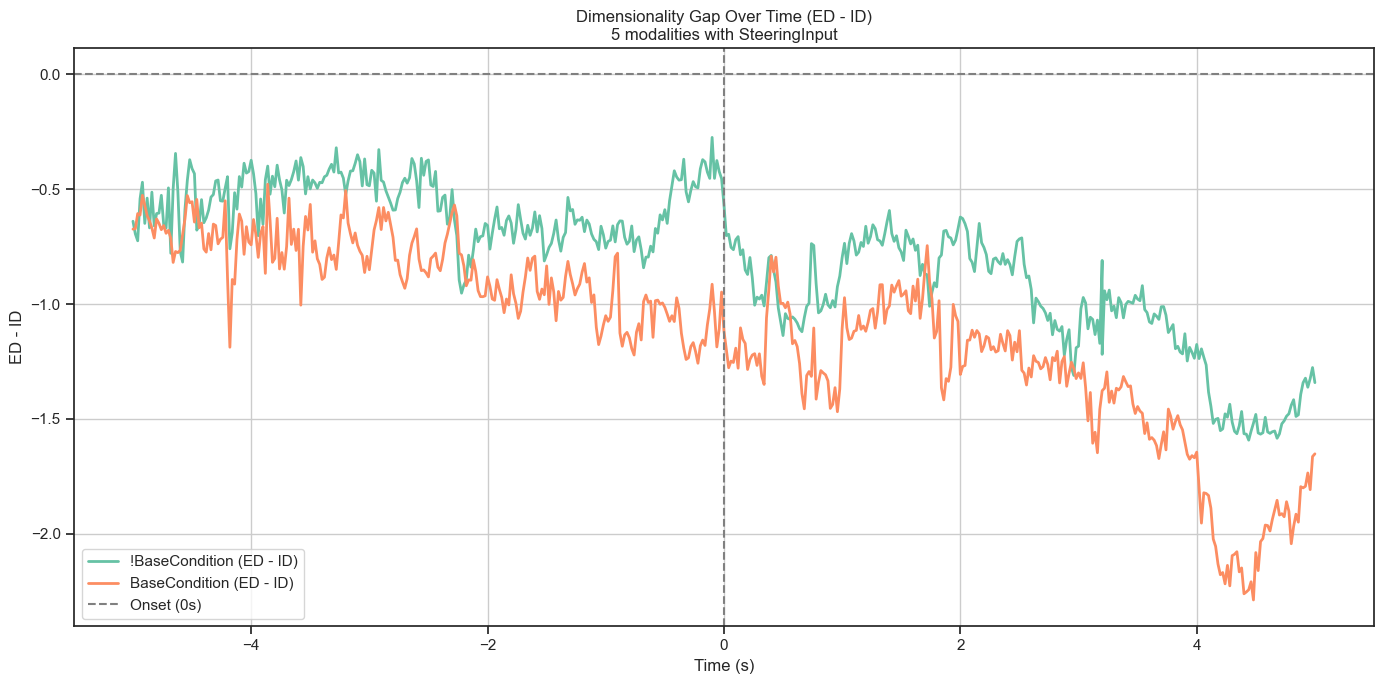

In [21]:
# Example usage (ensure 'modalities' is defined in your calling context)
plot_ed_for_modalities(len(modalities))